In [1]:
"""
https://www.tensorflow.org/tutorials/keras/regression
https://www.tensorflow.org/guide/keras/preprocessing_layers
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from pathlib import Path
import numpy as np
import pandas as pd

from df_collector import df_collector
from model_settings import ms
from convsklearn import convsklearn

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

def plot_relative_spot(x, y):
    plt.scatter(train_features['relative_spot'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('relative_spot')
    plt.ylabel('relative_price')
    plt.legend()

In [2]:
ms.find_root(Path())
datadir = os.path.join(ms.root,ms.cboe_spx_short_term_asians['dump'])
df = df_collector.collect_dfs(datadir).iloc[:,1:]

conv = convsklearn()
conv.load_data(df)

if datadir.find('asian') != -1:
	pricename = 'asian_price'

elif datadir.find('barrier') !=-1:
	pricename = 'barrier_price'
else:
	print('unknown model')
	pricename = ''



df['relative_price'] = df[pricename]/df['strike_price']
df['relative_spot'] = df['spot_price']/df['strike_price']

cats = conv.categorical_features
nums = conv.numerical_features
nums = [n for n in nums if n.find('strike_price')==-1 and n.find('spot_price')==-1]
nums = nums + ['relative_spot']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


In [5]:
dataset = df.copy()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='mixed')
dataset['date'] = dataset['calculation_date'].dt.floor('D')
dates = dataset['date'].drop_duplicates().reset_index(drop=True)
dataset.tail()

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,relative_price,relative_spot
338935,5857.0,7320.75,84,1.0,84,0,arithmetic,put,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,2.286232e-09,-0.717809,1.487001,0.121595,2024-10-14,1429.795085,0.195307,0.800055
338936,5857.0,8785.00,84,1.0,84,0,geometric,call,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,2.286232e-09,-0.717809,1.487001,0.121595,2024-10-14,0.000000,0.000000,0.666705
338937,5857.0,8785.00,84,1.0,84,0,geometric,put,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,2.286232e-09,-0.717809,1.487001,0.121595,2024-10-14,2887.934074,0.328735,0.666705
338938,5857.0,8785.00,84,1.0,84,0,arithmetic,call,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,2.286232e-09,-0.717809,1.487001,0.121595,2024-10-14,0.000000,0.000000,0.666705
338939,5857.0,8785.00,84,1.0,84,0,arithmetic,put,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,2.286232e-09,-0.717809,1.487001,0.121595,2024-10-14,2879.992268,0.327831,0.666705


In [6]:
dataset.isna().sum()

spot_price          0
strike_price        0
days_to_maturity    0
n_fixings           0
fixing_frequency    0
past_fixings        0
averaging_type      0
w                   0
risk_free_rate      0
dividend_rate       0
calculation_date    0
kappa               0
theta               0
rho                 0
eta                 0
v0                  0
date                0
asian_price         0
relative_price      0
relative_spot       0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
dataset = pd.get_dummies(dataset, columns=['w','averaging_type'], prefix='', prefix_sep='')
dataset.tail()

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,risk_free_rate,dividend_rate,calculation_date,kappa,...,eta,v0,date,asian_price,relative_price,relative_spot,call,put,arithmetic,geometric
338935,5857.0,7320.75,84,1.0,84,0,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,...,1.487001,0.121595,2024-10-14,1429.795085,0.195307,0.800055,False,True,True,False
338936,5857.0,8785.00,84,1.0,84,0,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,...,1.487001,0.121595,2024-10-14,0.000000,0.000000,0.666705,True,False,False,True
338937,5857.0,8785.00,84,1.0,84,0,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,...,1.487001,0.121595,2024-10-14,2887.934074,0.328735,0.666705,False,True,False,True
338938,5857.0,8785.00,84,1.0,84,0,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,...,1.487001,0.121595,2024-10-14,0.000000,0.000000,0.666705,True,False,True,False
338939,5857.0,8785.00,84,1.0,84,0,0.041813,0.012687,2024-10-14 15:26:27.717,4.067045,...,1.487001,0.121595,2024-10-14,2879.992268,0.327831,0.666705,False,True,True,False


In [9]:
development_dates = dates.iloc[:100]
test_dates = dates[~dates.isin(development_dates)]

In [10]:
train_dataset = dataset[dataset['date'].isin(development_dates)].copy()
test_dataset = dataset[dataset['date'].isin(test_dates)].copy()

In [11]:
target = 'relative_price'
train_features = train_dataset[nums+train_dataset.columns.tolist()[-4:]]
test_features = test_dataset[nums+test_dataset.columns.tolist()[-4:]]

train_labels = train_dataset[target]
test_labels = test_dataset[target]

In [12]:
train_features

,days_to_maturity,fixing_frequency,past_fixings,risk_free_rate,dividend_rate,kappa,theta,rho,eta,v0,relative_spot,call,put,arithmetic,geometric
0,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,True,False,False,True
1,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,False,True,False,True
2,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,True,False,True,False
3,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,False,True,True,False
4,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,1.333333,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23575,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.800000,False,True,True,False
23576,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,True,False,False,True
23577,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,False,True,False,True
23578,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,True,False,True,False


In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
spot_price,1367.137405,46.572735
strike_price,1366.866412,485.883325
days_to_maturity,48.222222,32.907225
n_fixings,2.777778,3.424747
fixing_frequency,31.111111,29.719477
past_fixings,0.0,0.0
risk_free_rate,0.001601,0.000254
dividend_rate,0.020649,0.000619
calculation_date,2012-05-26 12:22:49.002740736,NaN
kappa,6.499276,10.013034


In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

In [16]:
print(normalizer.mean.numpy())

[[48.222 31.111  0.     0.002  0.021  6.499  0.136 -0.794  1.894  0.089
   1.16   0.5    0.5    0.5    0.5  ]]


In [17]:
train_features

,days_to_maturity,fixing_frequency,past_fixings,risk_free_rate,dividend_rate,kappa,theta,rho,eta,v0,relative_spot,call,put,arithmetic,geometric
0,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,True,False,False,True
1,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,False,True,False,True
2,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,True,False,True,False
3,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,2.000000,False,True,True,False
4,7,7,0,0.001578,0.020858,3.183380,0.200851,-1.000000,0.601996,0.012430,1.333333,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23575,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.800000,False,True,True,False
23576,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,True,False,False,True
23577,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,False,True,False,True
23578,84,84,0,0.001726,0.021313,0.000002,0.318321,-0.353806,1.634967,0.056625,0.666667,True,False,True,False


# dnn

In [18]:
n_features = len(cats)+len(nums)
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(n_features, activation='relu'),
        layers.Dense(n_features, activation='relu'),
        layers.Dense(n_features, activation='relu'),
        layers.Dense(n_features, activation='relu'),
        layers.Dense(n_features, activation='relu'),
        layers.Dense(1, activation='relu')
    ])
    
    model.compile(loss='mean_squared_error',
    optimizer=tf.keras.optimizers.SGD(
                learning_rate=0.01,
                momentum=0.0,
                nesterov=False,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                loss_scale_factor=None,
                gradient_accumulation_steps=None,
                name='SGD'
            )
     )
    
    return model

In [19]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (23580, 15)                 │              31 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31 (128.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31 (128.00 B)

In [20]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=1, epochs=10)

Epoch 1/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - loss: 0.0820 - val_loss: 0.0453
Epoch 2/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0337 - val_loss: 0.0206
Epoch 3/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - loss: 0.0177 - val_loss: 0.0159
Epoch 4/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.0127 - val_loss: 0.0132
Epoch 5/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 0.0111 - val_loss: 0.0115
Epoch 6/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 0.0099 - val_loss: 0.0107
Epoch 7/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 0.0089 - val_loss: 0.0098
Epoch 8/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 0.0083 - val_loss: 0.0091
Epoch 9/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 0.0077 - val_loss: 0.0084
Epoch 10/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.0072 - val_loss: 0.0078
CPU times: total: 8.39 s
Wall time: 7.73 s


In [21]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [22]:
pd.DataFrame(test_results, index=['Mean absolute error']).T

,Mean absolute error
dnn_model,0.469433


In [23]:
test_predictions = dnn_model.predict(test_features).flatten()

9855/9855 ━━━━━━━━━━━━━━━━━━━━ 6s 579us/step


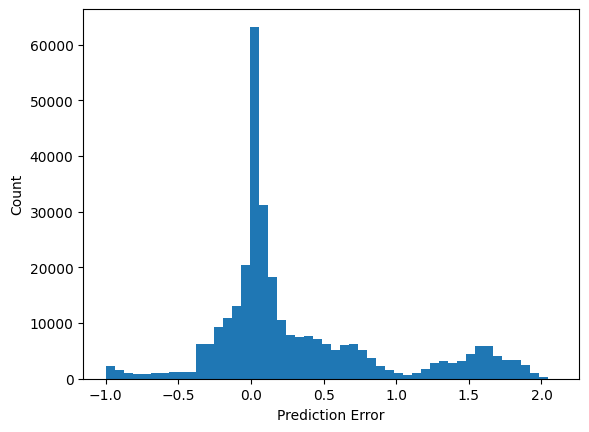

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins=50)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [26]:
test_dataset['prediction'] = test_predictions
test_dataset['error'] = error
test_dataset['calculation_date'] = pd.to_datetime(test_dataset['calculation_date'],format='mixed')
test_dataset = test_dataset.set_index('calculation_date')
test_dataset.dtypes

spot_price                 float64
strike_price               float64
days_to_maturity             int64
n_fixings                  float64
fixing_frequency             int64
past_fixings                 int64
risk_free_rate             float64
dividend_rate              float64
kappa                      float64
theta                      float64
rho                        float64
eta                        float64
v0                         float64
date                datetime64[ns]
asian_price                float64
relative_price             float64
relative_spot              float64
call                          bool
put                           bool
arithmetic                    bool
geometric                     bool
prediction                 float32
error                      float64
dtype: object

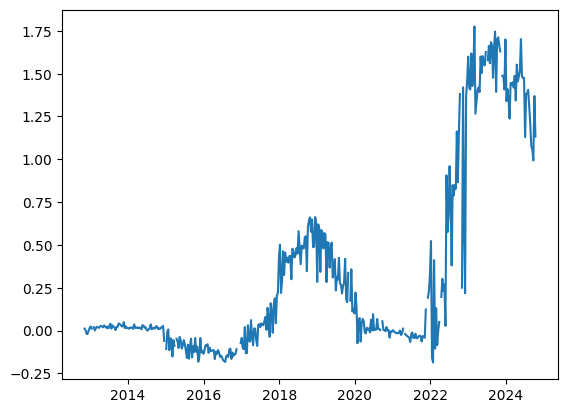

In [27]:
resampled = test_dataset['error'].resample('10D').mean()
plt.figure()
plt.plot(resampled)
plt.show()

737/737 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


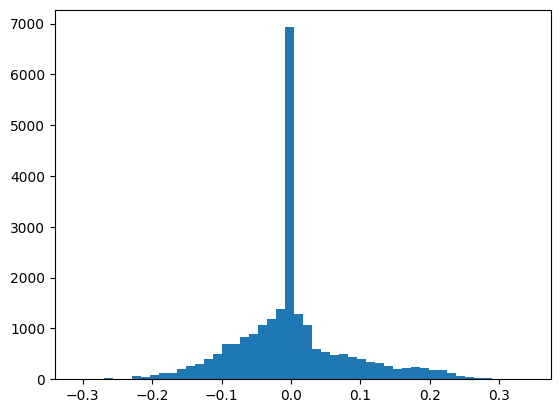

In [28]:
insample_prediction = dnn_model.predict(train_features).flatten()
insample_error = train_labels-insample_prediction
plt.figure()
plt.hist(insample_error,bins = 50)
plt.show()

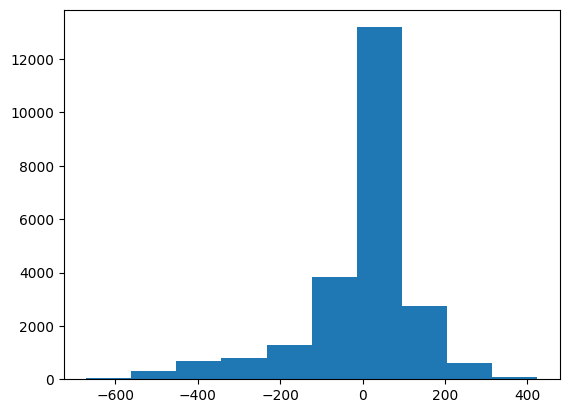

In [36]:
train_dataset['prediction'] = insample_prediction
train_dataset['error'] = insample_error
train_dataset['estimated'] = train_dataset['prediction']*train_dataset['strike_price']
train_dataset['pricing_error'] = train_dataset['estimated']-train_dataset[pricename]
plt.figure()
plt.hist(train_dataset['pricing_error'])
plt.show()